# Model Optimizer

Author: Ziyuan Tang

# 1. Performance Optimization

Optimize Mobile-net model from `mobile-net.py` using method presented in https://www.tensorflow.org/model_optimization/guide/quantization/post_training, compare performace and size of model.

### 1.1 Train Model

In [120]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
#%matplotlib inline

mobile = tf.keras.applications.mobilenet.MobileNet()


#for filename in os.listdir("/home/majid/Projects/ML/IoT/Lab3/Solution2/simple_images/bobcat-before/"):
#        if filename.endswith(".jpg"):
#           preprocessed_image=prepare_image(filename)
#           #save_path = 'data/MobileNet-samples/'
#           image.save_img("/home/majid/Projects/ML/IoT/Lab3/Solution2/data/MobileNet-samples/bobcat/"+filename, image.array_to_img(np.squeeze(preprocessed_image, axis=0)))

PATH= "MobileNet-samples/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

print(class_names)  
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()   
print(len(model.trainable_variables))

initial_epochs = 30


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

            

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['bobcat', 'cat']
Number of validation batches: 26
Number of test batches: 6
(32, 7, 7, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_27[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Co

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_8 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_18  (None, 1280)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0   

### 1.2 Float 16 Quantization

In [121]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = pathlib.Path("model16.tflite")
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: C:\Users\15047\AppData\Local\Temp\tmpnk9tj53b\assets


INFO:tensorflow:Assets written to: C:\Users\15047\AppData\Local\Temp\tmpnk9tj53b\assets
C:\Users\15047\anaconda3\envs\ensf511\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


4477328

### 1.3 Evaluating Model

In [163]:
import cv2

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='model16.tflite')
#allocate the tensors
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
pred_list = []
for i in os.listdir("MobileNet-samples/validation/bobcat"):
    input_image = cv2.imread("MobileNet-samples/validation/bobcat/"+i)

    np.expand_dims(input_image, axis=0).astype(np.float32)
    test_image = np.reshape(input_image.astype(np.float32),input_shape)

    interpreter.set_tensor(input_details[0]['index'], test_image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]["index"])
    if predictions<0:
        pred_list.append(0)
    else:
        pred_list.append(1)
for i in os.listdir("MobileNet-samples/validation/cat"):
    input_image = cv2.imread("MobileNet-samples/validation/cat/"+i)

    np.expand_dims(input_image, axis=0).astype(np.float32)
    test_image = np.reshape(input_image.astype(np.float32),input_shape)

    interpreter.set_tensor(input_details[0]['index'], test_image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]["index"])
    if predictions<0:
        pred_list.append(0)
    else:
        pred_list.append(1)

actual_label = np.concatenate([np.zeros(500).astype(np.int16),np.ones(500).astype(np.int16)])
result = pred_list ==actual_label


In [168]:
accuracy16 = np.count_nonzero(result)/len(result)
print("accuracy of Float16 Quantization Model: {}".format(accuracy))

accuracy of Float16 Quantization Model: 0.96875


### 1.4 Float 16 Quantization

The float16 quantization model has an accuracy of 0.96875 after 30 epochs training, compare to the original model's accuracy of 0.979 which drops by 1%. Float16 quantization only drops a minimum percentage of accuracy. 

The file size of float16 quantization model has is 4373KB compare to the original model size of 8665KB, which halfed the the file size of the model.

The result shows that float16 quantization can reduce the size of the model with sacrificing minimum accuracy.

## 2.0 Training with 112*112 Image

In [35]:

#%matplotlib inline

mobile = tf.keras.applications.mobilenet.MobileNet()



PATH= "MobileNet-samples/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (112, 112)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

print(class_names)  
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()   
print(len(model.trainable_variables))

initial_epochs = 30


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['bobcat112', 'cat112']
Number of validation batches: 26
Number of test batches: 6


(32, 4, 4, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 56, 56, 32)   864         input_18[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 56, 56, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 56, 56, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 112, 112, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 112, 112, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 112, 112, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 112, 112, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_12  (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0   

In [39]:
model.save("model112.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model112.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\15047\AppData\Local\Temp\tmpb5vwc1a2\assets


INFO:tensorflow:Assets written to: C:\Users\15047\AppData\Local\Temp\tmpb5vwc1a2\assets
C:\Users\15047\anaconda3\envs\ensf511\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


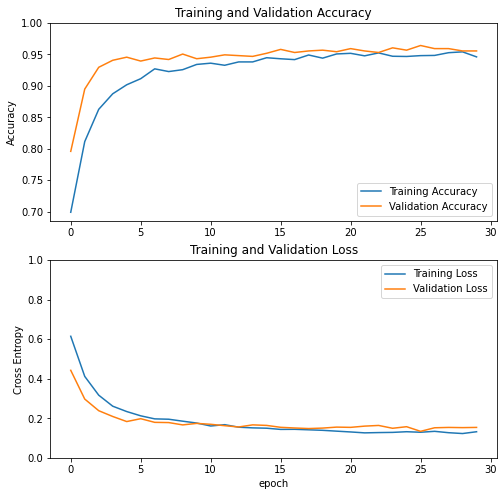

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()                    

In [40]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 128ms/step - loss: 0.1242 - accuracy: 0.9688
Test accuracy : 0.96875


### 2.1 112*112 Model Discussion 

The accuracy of the 112 * 112 model is 96.9% compare to 224 * 224 model which is 97.9% which is very close. The loss of 112 * 112 model is slightly higher than the 224 * 224 model but also close as both model converges around 0.2. In general, the two model's performance are similar.

The 112 * 112 model's `.tflite` file size is 8666 kb compare to the 224*224 model which is 8665 kb which are same.

The trainning time for 112 * 112 model is 17s compare to 224 * 224 model which provides a shorter trainning time for the model.


## 3.0 Conclusion

In this lab, the original model trains to classify 224 * 224 cat and bobcat images. The accuracy of the original model is 0.979 with its file size of 8665KB. The original model is then quantized using float16 quantization method. Float16 quantization model has accuracy of 0.96875 with a file size of 4373KB. Float16 quantization method is able to half the size of the original model with sacrificing only 1% accuracy, which might be desirable for mobile devices that requires smaller file size and faster computation.

The original model was trained with 122 * 122 images. The processing time of trainning one epoch is 16s compare to 50s from the original model.  The accuracy after is 0.96875 which is the same as the float16 quantization model. The file size of the 122 * 122 model is 8666KB. The model trained with a smaller image size does not reduce the file size of the model, but it reduces trainning time of one epoch with losing only a small percentage of accuracy which may be desirable to save trainning time.